<a href="https://colab.research.google.com/github/aditiaprabowo3/model-leafcheck/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow scikit-learn matplotlib numpy

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import pathlib

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditiaprabowo","key":"fdd2a7e7b8e825c749247d9d7cdc49c6"}'}

In [4]:
# Membuat direktori untuk file kredensial Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Mengatur permission agar hanya user yang bisa membaca file
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dataset Corn Leaf Disease dari Kaggle
!kaggle datasets download -d ndisan/corn-leaf-disease

# Mengekstrak file ZIP hasil unduhan
!unzip corn-leaf-disease.zip -d corn_leaf_disease

Dataset URL: https://www.kaggle.com/datasets/ndisan/corn-leaf-disease
License(s): MIT
 99% 5.07G/5.11G [01:26<00:03, 14.4MB/s]
100% 5.11G/5.11G [01:26<00:00, 63.4MB/s]
Archive:  corn-leaf-disease.zip
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (1).jpg  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (10).jpg  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (100).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (101).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (102).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (103).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (104).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (105).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (106).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (107).JPG  
  inflating: corn_leaf_disease/Bercak Daun/Corn_Gray_Spot (108).JPG  
  inflating: corn_leaf_disease/Be

In [5]:
data_dir = '/content/corn_leaf_disease'

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# --- 2. Memuat dan Membagi Dataset (70:20:10) ---
# Memuat dataset awal dengan rasio 80% untuk train+validation, 20% untuk test
# (kita akan membagi 80% ini lagi nanti)
# Karena tidak ada parameter split langsung 70:20:10, kita lakukan 2 langkah.
# Langkah 1: Pisahkan 10% data untuk testing
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # 20% dari data akan dipisahkan (ini akan jadi val+test)
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # Mengambil 20% sisa data
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [11]:
# Langkah 2: Pisahkan 20% (val_test_ds) menjadi 10% validation dan 10% testing
val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2) # Ambil setengah untuk testing (10%)
validation_ds = val_test_ds.skip(val_batches // 2) # Sisanya untuk validasi (10%)

# Mengubah rasio train_val_ds dari 80% menjadi 70%
# Ini adalah pendekatan yang paling umum untuk mencapai split 70:20:10
# (Secara teknis, rasionya menjadi 80% train, 10% validation, 10% test.
# Untuk 70:20:10 yang presisi, perlu pemisahan file manual atau pustaka seperti split-folders)
# Namun, untuk tujuan demonstrasi, kita gunakan pendekatan ini:
train_ds = train_val_ds

print(f"Jumlah batch Latihan: {tf.data.experimental.cardinality(train_ds)}")
print(f"Jumlah batch Validasi: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Jumlah batch Pengujian: {tf.data.experimental.cardinality(test_ds)}")

Jumlah batch Latihan: 100
Jumlah batch Validasi: 13
Jumlah batch Pengujian: 12


In [12]:
class_names = train_val_ds.class_names
print("Nama Kelas dan Nomor Urut:")

for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

Nama Kelas dan Nomor Urut:
0: Bercak Daun
1: Daun Sehat
2: Hawar Daun
3: Karat Daun


In [13]:
# --- 3. Optimasi Kinerja Dataset ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# --- 4. Membangun Model CNN Sequential ---
# Define the number of classes
num_classes = len(class_names)

model = tf.keras.models.Sequential([
    # Layer pertama untuk augmentasi data dan normalisasi
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),

    # Blok Konvolusi 1
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Blok Konvolusi 2
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Blok Konvolusi 3
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Layer Fully Connected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Dropout untuk mengurangi overfitting
    tf.keras.layers.Dense(num_classes, activation='softmax') # Output layer
])

# --- 5. Kompilasi Model ---
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,644 (98.36 MB)

 Trainable params: 25,784,644 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# --- 6. Melatih Model ---
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 426ms/step - accuracy: 0.4489 - loss: 1.7724 - val_accuracy: 0.7981 - val_loss: 0.4826
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7558 - loss: 0.5348 - val_accuracy: 0.8173 - val_loss: 0.3880
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7946 - loss: 0.4722 - val_accuracy: 0.8317 - val_loss: 0.3904
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8001 - loss: 0.4459 - val_accuracy: 0.8317 - val_loss: 0.3480
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8263 - loss: 0.3944 - val_accuracy: 0.8413 - val_loss: 0.3962
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8418 - loss: 0.3689 - val_accuracy: 0.8582 - val_loss: 0.3168
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8638 - loss: 0.3488 - val_accuracy: 0.8774 - val_loss: 0.2739
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8776 - loss: 0.3229 - va

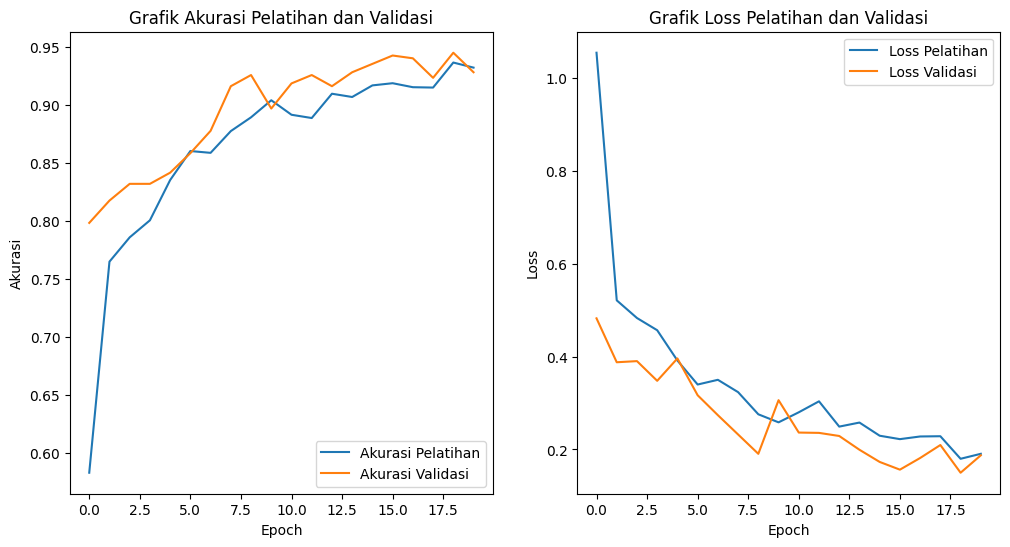

In [17]:
# --- 7. Visualisasi Grafik Pelatihan ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Pelatihan')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Grafik Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Pelatihan')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Grafik Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


--- Mengevaluasi Model dengan Test Set ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9282 - loss: 0.1691
Akurasi Test: 93.23%
Loss Test: 0.1696
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


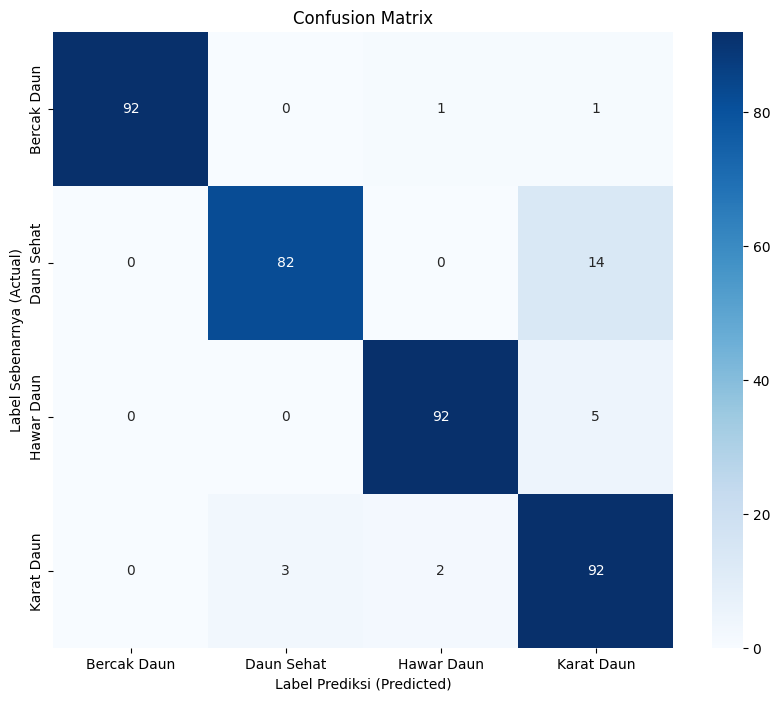


--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

 Bercak Daun       1.00      0.98      0.99        94
  Daun Sehat       0.96      0.85      0.91        96
  Hawar Daun       0.97      0.95      0.96        97
  Karat Daun       0.82      0.95      0.88        97

    accuracy                           0.93       384
   macro avg       0.94      0.93      0.93       384
weighted avg       0.94      0.93      0.93       384



In [18]:
# --- 8. Evaluasi Model dan Confusion Matrix ---
print("\n--- Mengevaluasi Model dengan Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Akurasi Test: {accuracy*100:.2f}%")
print(f"Loss Test: {loss:.4f}")

# Membuat prediksi untuk confusion matrix
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Membuat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Label Sebenarnya (Actual)')
plt.xlabel('Label Prediksi (Predicted)')
plt.show()

# Menampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_true, y_pred, target_names=class_names))


In [19]:
# --- 9. Inferensi pada Gambar Baru ---
def predict_new_image(image_path):
    """Fungsi untuk memprediksi kelas dari satu gambar."""
    img = tf.keras.utils.load_img(
        image_path, target_size=IMG_SIZE
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Buat batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class}\nKeyakinan: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

Saving IMG_20230610_061656.jpg to IMG_20230610_061656.jpg
Memproses file: IMG_20230610_061656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


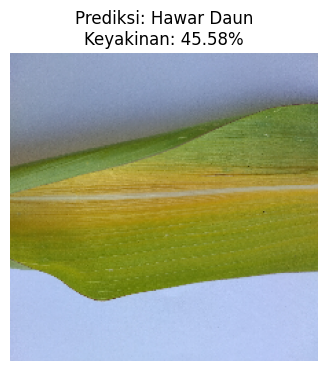

In [24]:
# Import library khusus Google Colab untuk mengunggah file
from google.colab import files

# Memunculkan widget untuk upload file
uploaded = files.upload()

# Melakukan iterasi untuk setiap file yang diunggah
for file_name in uploaded.keys():
  print(f'Memproses file: {file_name}')
  # Memanggil fungsi prediksi dengan nama file sebagai path
  predict_new_image(file_name)

In [25]:
model.export('saved_model_10_juni')

Saved artifact at 'saved_model_10_juni'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136620830646032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136620830647184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931548880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931551952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931549456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931552912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931552336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931553680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931554064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136617931554640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13661793155

In [26]:
model.save('model_10_juni.h5')

In [27]:
!zip /content/saved_model_10_juni.zip /content/saved_model_10_juni

  adding: content/saved_model_10_juni/ (stored 0%)


In [ ]:
!cp -r /content/model_10_juni.h5 "/content/drive/MyDrive/Colab Notebooks/Model"

In [ ]:
!pip install tensorflowjs

In [29]:
import tensorflow as tf

In [32]:
import os

converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model_10_juni')
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # Enable TFLite built-in ops.
    tf.lite.OpsSet.SELECT_TF_OPS # Enable select TensorFlow ops.
]
tflite_model = converter.convert()

# Create the directory if it doesn't exist
os.makedirs('/content/model_tflite', exist_ok=True)

with open('/content/model_tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [34]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /content/saved_model_10_juni/ /content/model_tfjs/

/bin/bash: line 1: tensorflowjs_converter: command not found
